## Testing the Evaluation methods and Data reading

* Using prequential, test-then-train and windowed evaluation. 
* We show how using either CSV or ARFF the API works.
* The CSV reader infer the task (classification or regression), but one can force the task to be interpreted as regression.

**Notebook last update: 08/12/2023**

In [1]:
from capymoa.evaluation import windowed_evaluation, prequential_evaluation, test_then_train_evaluation, prequential_evaluation_multiple_learners

capymoa_root: /home/antonlee/github.com/tachyonicClock/MOABridge/src/capymoa
MOA jar path location (config.ini): jar/moa.jar
JVM Location (system): 
JAVA_HOME: /usr/lib/jvm/java-17-openjdk
JVM args: ['-Xmx8g', '-Xss10M']
Sucessfully started the JVM and added MOA jar to the class path


# File paths

In [2]:
# Classification
arff_elec_path = '../data/electricity.arff'
csv_elec_path = '../data/electricity.csv'
# Stream with 100k instances
rbf_path = '../data/RBFm_100k.arff'
# Stream with 580k instances and around 100 features (csv)
covtfd_csv_file_path = '../data/covtFD.csv'
# Regression
csv_fried_path = '../data/fried.csv'

# Classification evaluation

## 0) [CLASSIFICATION] Reading a stream from a CSV file and using one learner
* Uses the ClassificationWindowedEvaluator directly

In [3]:
from capymoa.evaluation import ClassificationWindowedEvaluator
from capymoa.stream import stream_from_file

from capymoa.learner.classifier import AdaptiveRandomForest

stream = stream_from_file(path_to_csv_or_arff=csv_elec_path)
ARF = AdaptiveRandomForest(schema=stream.get_schema(), CLI="-s 5 -x (ADWINChangeDetector -a 0.001) -p (ADWINChangeDetector -a 0.01)")
evaluator = ClassificationWindowedEvaluator(schema=stream.get_schema(), window_size=4500)

while stream.has_more_instances():
    instance = stream.next_instance()
    prediction = ARF.predict(instance)
    evaluator.update(instance.y(), prediction)
    ARF.train(instance)

display(evaluator.metrics_per_window())

,classified instances,classifications correct (percent),Kappa Statistic (percent),Kappa Temporal Statistic (percent),Kappa M Statistic (percent)
0,4500.0,88.355556,75.503335,27.922971,70.328426
1,9000.0,86.311111,72.447892,18.410596,70.212766
2,13500.0,88.355556,76.702644,20.726172,75.627907
3,18000.0,86.355556,71.799141,5.246914,67.461579
4,22500.0,86.844444,71.739671,17.548747,66.420874
5,27000.0,84.955556,68.435024,-18.356643,63.796791
6,31500.0,84.755556,67.490884,-25.182482,60.867085
7,36000.0,84.200000,67.055826,-19.495798,60.478043
8,40500.0,85.444444,70.466772,1.799100,66.427473
9,45000.0,87.911111,75.530434,22.285714,75.539568


## 1) [CLASSIFICATION] Reading from an ARFF file and using 2 learners
* Uses the ClassificationEvaluator, thus it uses a cumulative approach for calculating the metrics (not windowed)

In [4]:
from capymoa.evaluation import ClassificationEvaluator
from capymoa.stream import stream_from_file

from capymoa.learner.classifier import OnlineBagging, AdaptiveRandomForest

stream = stream_from_file(path_to_csv_or_arff=arff_elec_path)
OB_learner = OnlineBagging(schema=stream.get_schema(), ensemble_size=5)
ARF_learner = AdaptiveRandomForest(schema=stream.get_schema(), ensemble_size=5)

# Not a windowed evaluator!
OB_evaluator = ClassificationEvaluator(schema=stream.get_schema())
ARF_evaluator = ClassificationEvaluator(schema=stream.get_schema())

while stream.has_more_instances():
    instance = stream.next_instance()
    
    OB_prediction = OB_learner.predict(instance)
    ARF_prediction = ARF_learner.predict(instance)
    
    OB_evaluator.update(instance.y(), OB_prediction)
    ARF_evaluator.update(instance.y(), ARF_prediction)

    OB_learner.train(instance)
    ARF_learner.train(instance)

print(f"OB final accuracy = {OB_evaluator.accuracy()} and ARF final accuracy = {ARF_evaluator.accuracy()}")

OB final accuracy = 79.05190677966102 and ARF final accuracy = 86.36564265536724


## 2) [CLASSIFICATION] Reading the data from a CSV, then evaluating it using two learners. 
* **Using the ```prequential_evaluation``` which internally executes both ```ClassificationWindowedEvaluator``` and ```ClassificationEvaluator```**
* ```prequential_evaluation``` allow us to have the windowed and cumulative results. So we can inspect the last accuracy and over time too. 
* We also plot the final results using ```plot_windowed_results```

OnlineBagging final accuracy = 78.65686793785311 and     AdaptiveRandomForest  final accuracy = 85.24231991525424


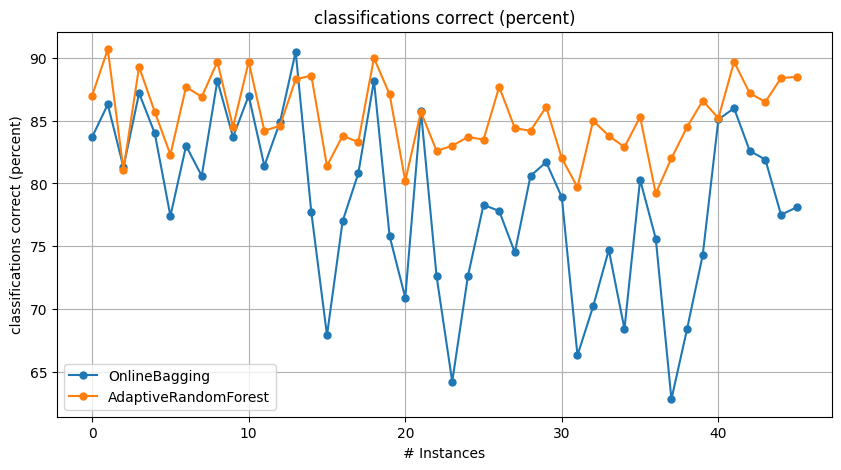

In [5]:
from capymoa.evaluation.visualization import plot_windowed_results

from capymoa.evaluation import ClassificationWindowedEvaluator
from capymoa.stream import stream_from_file

from capymoa.learner.classifier import OnlineBagging, AdaptiveRandomForest

stream = stream_from_file(path_to_csv_or_arff=csv_elec_path)
OB_learner = OnlineBagging(schema=stream.get_schema(), ensemble_size=2)
ARF_learner = AdaptiveRandomForest(schema=stream.get_schema(), ensemble_size=2)

OB_results = prequential_evaluation(stream=stream, learner=OB_learner, window_size=1000)
stream.restart()
ARF_results = prequential_evaluation(stream=stream, learner=ARF_learner, window_size=1000)

print(f"{OB_results['learner']} final accuracy = {OB_results['cumulative'].accuracy()} and \
    {ARF_results['learner']}  final accuracy = {ARF_results['cumulative'].accuracy()}")

plot_windowed_results(OB_results, ARF_results)

## 3) [CLASSIFICATION] Simple test-then-train evaluation (cumulative). 

In [6]:
stream = stream_from_file(path_to_csv_or_arff=arff_elec_path)

l = OnlineBagging(schema=stream.get_schema(), ensemble_size=2)

res = test_then_train_evaluation(stream, l)
print(res['cumulative'].accuracy())
print(res)

78.65686793785311
{'learner': 'OnlineBagging', 'cumulative': <capymoa.evaluation.evaluation.ClassificationEvaluator object at 0x7f6eac1dd760>, 'wallclock': 0.17650246620178223, 'cpu_time': 0.3714270000000006}


## 4) [CLASSIFICATION] Simple windowed evaluation

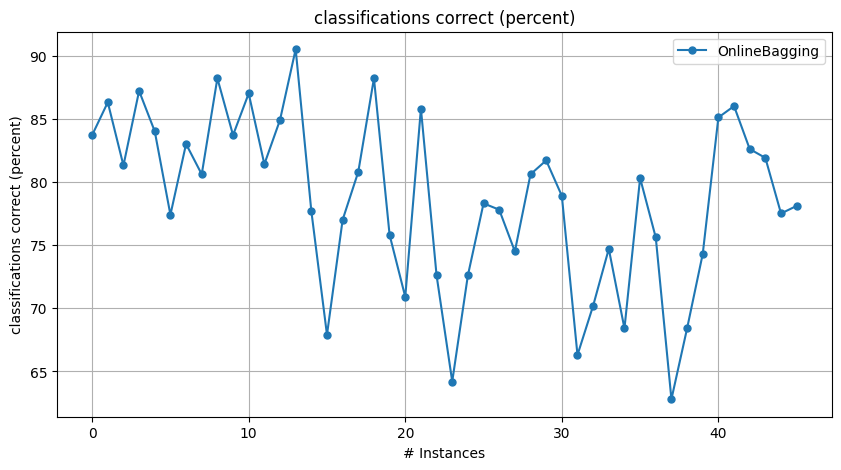

In [7]:
stream = stream_from_file(path_to_csv_or_arff=arff_elec_path)

l = OnlineBagging(schema=stream.get_schema(), ensemble_size=2)

res = windowed_evaluation(stream, l)
plot_windowed_results(res)

## 5) [CLASSIFICATION] Prequential evaluation, single stream, multiple learners. 
* Important: the ```prequential_evaluation_multiple_learners``` iterate through the stream testing and training with each learner
* This method does not calculate ```wallclock``` or ```cpu_time``` because the training and testing of each learner is interleaved

OB final accuracy = 78.65686793785311 and ARF final accuracy = 85.24231991525424


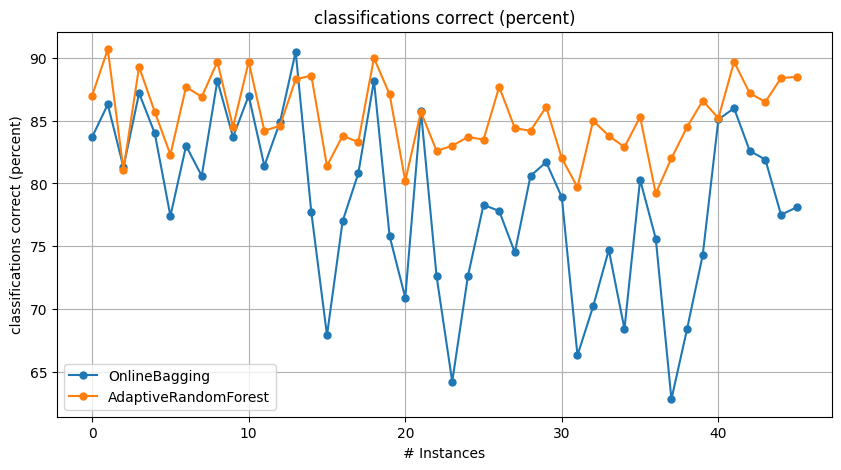

In [8]:
stream = stream_from_file(path_to_csv_or_arff=arff_elec_path)

# Define the learners + an alias (dictionary key)
learners = {
    'OB': OnlineBagging(schema=stream.get_schema(), ensemble_size=2),
    'ARF': AdaptiveRandomForest(schema=stream.get_schema(), ensemble_size=2)
}

results = prequential_evaluation_multiple_learners(stream, learners)

print(f"OB final accuracy = {results['OB']['cumulative'].accuracy()} and ARF final accuracy = {results['ARF']['cumulative'].accuracy()}")
plot_windowed_results(results['OB'], results['ARF'], metric="classifications correct (percent)")

## 6) [CLASSIFICATION] prequential_evaluation with a larger stream (100k instances)

{'learner': 'OnlineBagging',
 'cumulative': <capymoa.evaluation.evaluation.ClassificationEvaluator at 0x7f6dd9eb9b50>,
 'windowed': <capymoa.evaluation.evaluation.ClassificationWindowedEvaluator at 0x7f6ead2bfa60>,
 'wallclock': 2.967083215713501,
 'cpu_time': 3.7073500000000017}

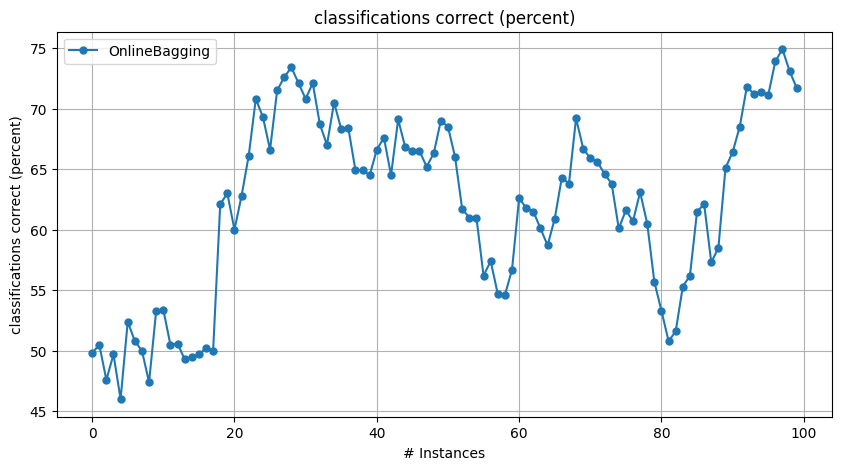

In [9]:
stream = stream_from_file(path_to_csv_or_arff=rbf_path, class_index=-1)

l = OnlineBagging(schema=stream.get_schema(), ensemble_size=10)

res = prequential_evaluation(stream, l, window_size=1000)
display(res)
plot_windowed_results(res)

## 7) [CLASSIFICATION] Reading the data from a large CSV
* Using the covtFD.csv file with more than 580k instances and 100 features


In [10]:
%%time
from capymoa.stream import stream_from_file

# Loads the csv data to memory, it should take from 1 minute to 2 minutes. 
stream = stream_from_file(path_to_csv_or_arff=covtfd_csv_file_path, class_index=-1)

CPU times: user 1min 58s, sys: 2.35 s, total: 2min
Wall time: 1min 57s


In [11]:
from capymoa.learner import MOAClassifier
from capymoa.evaluation import test_then_train_evaluation
from moa.classifiers.bayes import NaiveBayes

learner = MOAClassifier(moa_learner=NaiveBayes())

stream.restart()

results = test_then_train_evaluation(stream=stream, learner=learner, max_instances=None, sample_frequency=None)

display(results)
display(results['cumulative'].metrics_per_window())
print(results['cumulative'].accuracy())

{'learner': 'NaiveBayes',
 'cumulative': <capymoa.evaluation.evaluation.ClassificationEvaluator at 0x7f6dbfc54340>,
 'wallclock': 19.098124980926514,
 'cpu_time': 19.122420000000005}

,classified instances,classifications correct (percent),Kappa Statistic (percent),Kappa Temporal Statistic (percent),Kappa M Statistic (percent)


57.97274061936866


# Regression evaluation

## 0) [REGRESSION] Reading a stream from a CSV file and using one learner
* Uses the ```RegressionWindowedEvaluator``` directly

In [12]:
from capymoa.evaluation import RegressionWindowedEvaluator
from capymoa.stream import stream_from_file

from capymoa.learner.regressor import AdaptiveRandomForestRegressor

stream = stream_from_file(path_to_csv_or_arff=csv_fried_path, enforce_regression=True)
ARF = AdaptiveRandomForestRegressor(schema=stream.get_schema(), ensemble_size=5)


evaluator = RegressionWindowedEvaluator(schema=stream.get_schema(), window_size=5000)

while stream.has_more_instances():
    instance = stream.next_instance()
    prediction = ARF.predict(instance)
    evaluator.update(instance.y(), prediction)
    ARF.train(instance)

display(evaluator.metrics_per_window())

,classified instances,mean absolute error,root mean squared error,relative mean absolute error,relative root mean squared error,coefficient of determination,adjusted coefficient of determination
0,5000.0,3.301312,4.212785,0.826254,0.855881,0.267467,0.265852
1,5000.0,2.981176,3.867996,0.727015,0.767106,0.411548,0.410250
2,5000.0,2.828599,3.704090,0.696853,0.740711,0.451348,0.450138
3,5000.0,2.812868,3.685687,0.690389,0.733612,0.461814,0.460627
4,5000.0,2.802291,3.656377,0.695275,0.734827,0.460029,0.458838
5,5000.0,2.742057,3.593869,0.683031,0.726970,0.471515,0.470349
6,5000.0,2.766988,3.633832,0.662587,0.709115,0.497156,0.496047
7,5000.0,2.708092,3.537754,0.664940,0.707693,0.499170,0.498066


## 1) [REGRESSION] Reading from an ARFF file and using 2 learners
* Uses the RegressionEvaluator, thus it uses a cumulative approach for calculating the metrics (not windowed)

In [13]:
from capymoa.evaluation import RegressionEvaluator
from capymoa.stream import stream_from_file

from capymoa.learner.regressor import KNNRegressor, AdaptiveRandomForestRegressor

stream = stream_from_file(path_to_csv_or_arff=csv_fried_path, enforce_regression=True)
kNN_learner = KNNRegressor(schema=stream.get_schema(), k=5)
ARF_learner = AdaptiveRandomForestRegressor(schema=stream.get_schema(), ensemble_size=5)

# Not a windowed evaluator!
kNN_evaluator = RegressionEvaluator(schema=stream.get_schema())
ARF_evaluator = RegressionEvaluator(schema=stream.get_schema())

while stream.has_more_instances():
    instance = stream.next_instance()
    
    kNN_prediction = kNN_learner.predict(instance)
    ARF_prediction = ARF_learner.predict(instance)
    
    kNN_evaluator.update(instance.y(), kNN_prediction)
    ARF_evaluator.update(instance.y(), ARF_prediction)

    kNN_learner.train(instance)
    ARF_learner.train(instance)

print(f"OB final MAE = {kNN_evaluator.MAE()} and ARF final MAE = {ARF_evaluator.MAE()}")

OB final MAE = 2.171382783882719 and ARF final MAE = 2.864632534308498


## 2) [REGRESSION] Reading the data from a CSV, then evaluating it using two learners. 
* **Using the ```prequential_evaluation``` which internally executes both ```RegressionWindowedEvaluator``` and ```RegressionEvaluator```**
* ```prequential_evaluation``` allow us to have the windowed and cumulative results. So we can inspect the last accuracy and over time too. 
* We also plot the final results using ```plot_windowed_results```

kNNRegressor final RMSE = 2.7394543131282583 and     AdaptiveRandomForestRegressor  final accuracy = 3.303185689295369


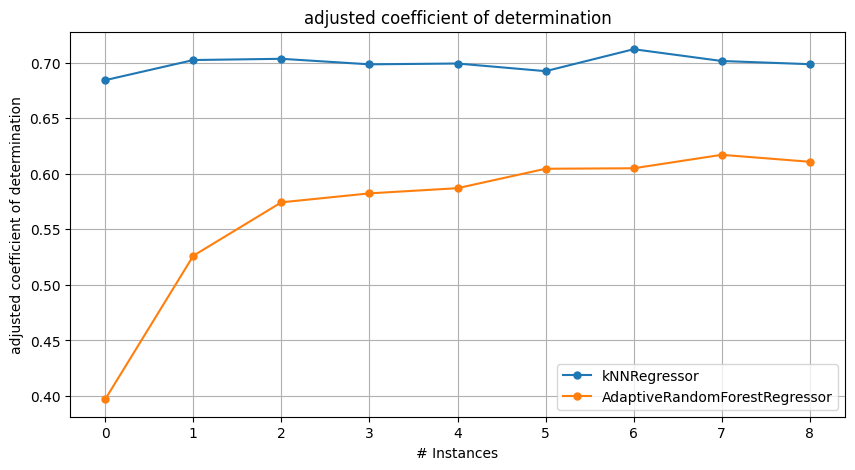

In [14]:
from capymoa.evaluation.visualization import plot_windowed_results

from capymoa.evaluation import prequential_evaluation
from capymoa.stream import stream_from_file

from capymoa.learner.regressor import KNNRegressor, AdaptiveRandomForestRegressor

stream = stream_from_file(path_to_csv_or_arff=csv_fried_path, enforce_regression=True)
kNN_learner = KNNRegressor(schema=stream.get_schema(), k=5)
ARF_learner = AdaptiveRandomForestRegressor(schema=stream.get_schema(), ensemble_size=10)

kNN_results = prequential_evaluation(stream=stream, learner=kNN_learner, window_size=5000)
stream.restart()
ARF_results = prequential_evaluation(stream=stream, learner=ARF_learner, window_size=5000)

print(f"{kNN_results['learner']} final RMSE = {kNN_results['cumulative'].RMSE()} and \
    {ARF_results['learner']}  final accuracy = {ARF_results['cumulative'].RMSE()}")

plot_windowed_results(kNN_results, ARF_results, metric='adjusted coefficient of determination')

## 4) [REGRESSION] Simple test-then-train evaluation (cumulative). 

In [15]:
stream = stream_from_file(path_to_csv_or_arff=csv_fried_path, enforce_regression=True)

kNN_learner = KNNRegressor(schema=stream.get_schema(), k=5)

res = test_then_train_evaluation(stream, kNN_learner)
print(res['cumulative'].MAE())
print(res)

2.171382783882719
{'learner': 'kNNRegressor', 'cumulative': <capymoa.evaluation.evaluation.RegressionEvaluator object at 0x7f6dbfc7d8e0>, 'wallclock': 5.498424053192139, 'cpu_time': 5.52109200000001}


## 5) [REGRESSION] Prequential evaluation, single stream, multiple learners. 
* Important: the ```prequential_evaluation_multiple_learners``` iterate through the stream testing and training with each learner
* This method does not calculate ```wallclock``` or ```cpu_time``` because the training and testing of each learner is interleaved

kNNReg_k5: {'classified instances': 40768.0, 'mean absolute error': 2.171382783882719, 'root mean squared error': 2.7394543131282583, 'relative mean absolute error': 0.5343076205436615, 'relative root mean squared error': 0.5474215436522585, 'coefficient of determination': 0.7003296535453785, 'adjusted coefficient of determination': 0.7002487728453343} 

kNNReg_k2: {'classified instances': 40768.0, 'mean absolute error': 2.455209968602826, 'root mean squared error': 3.101880727919028, 'relative mean absolute error': 0.6041483823103337, 'relative root mean squared error': 0.6198447362911451, 'coefficient of determination': 0.6157925028921607, 'adjusted coefficient of determination': 0.6156888057072509} 

kNNReg_k5_median: {'classified instances': 40768.0, 'mean absolute error': 2.3265919348508635, 'root mean squared error': 2.95901097128398, 'relative mean absolute error': 0.5724996117282386, 'relative root mean squared error': 0.5912952611845242, 'coefficient of determination': 0.65036

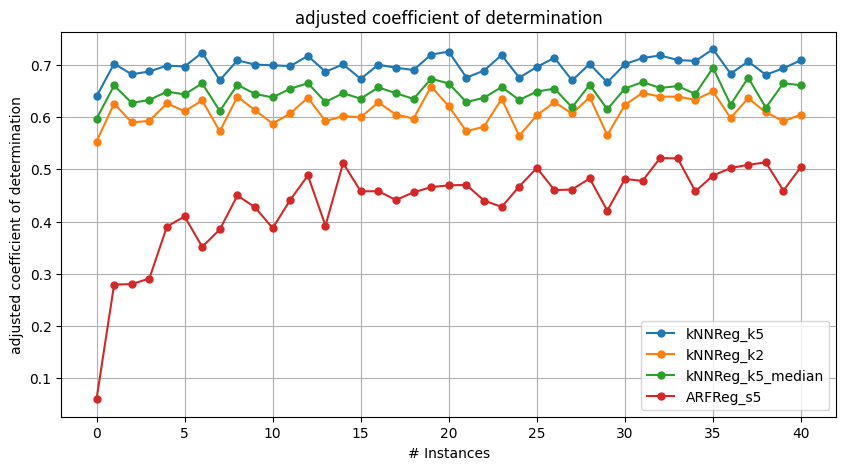

In [16]:
stream = stream_from_file(path_to_csv_or_arff=csv_fried_path, enforce_regression=True)

# Define the learners + an alias (dictionary key)
learners = {
    'kNNReg_k5': KNNRegressor(schema=stream.get_schema(), k=5),
    'kNNReg_k2': KNNRegressor(schema=stream.get_schema(), k=2),
    'kNNReg_k5_median': KNNRegressor(schema=stream.get_schema(), CLI='-k 5 -m'),
    'ARFReg_s5': AdaptiveRandomForestRegressor(schema=stream.get_schema(), ensemble_size=5)
}

results = prequential_evaluation_multiple_learners(stream, learners)

for learner_id in results.keys():
    print(f"{learner_id}: {results[learner_id]['cumulative']} \n")
    results[learner_id]['learner']=learner_id # sets the identifiers correctly for plotting

plot_windowed_results(results['kNNReg_k5'], results['kNNReg_k2'], results['kNNReg_k5_median'], 
                      results['ARFReg_s5'], metric="adjusted coefficient of determination")